Link to my repo: https://github.com/Rita-Barco/IntelligentSystems.git

# Dataset 1 - Classification task using ANFIS

In [99]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas

Firstly, the dataset is loaded and the features (X) and target (y) are extracted as arrays. Next, the data is split into 80% training and 20% testing to evaluate the model performance, specifying a random state so that the data division will be equal at each run. Features are then scaled to have mean 0 and a standard deviation equal to 1, which helps models to converge faster and perform better.

In [100]:
# load dataset
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data.values
y = diabetes.target.values
X.shape

# train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

The following code performs fuzzy C-means clustering on the training data. The feature matrix and target values are concatenated and transposed to match the input format expected by the library used.

The algorithm is configured with two clusters and a fuzziness parameter of 2 and it outputs the cluster centers, membership matrices, distances, objective function history, number of interations and the fuzzy partition coefficent.

In [101]:
 # Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

centers.shape

(2, 11)

This section computes the spread of each cluster, which quantifies how dispersed the data points are around the cluster centers.

In [102]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Here, the fuzzy memberships are converted into hard cluster assignments by selecting, for each sample, the cluster with the highest membership degree.

The fuzzy partition coefficient (FPC) is printed to evaluate the clustering quality. The obtained value of 0.86 indicates a good clustering, as values closer to 1 indicate more distinct clusters. 

A scatter plot of the first two features is also generated, where each point’s transparency reflects its membership degree to the cluster, providing a visual representation of how strongly each sample belongs to its assigned cluster. 

Fuzzy partition coefficient (FPC): 0.8556224894219073


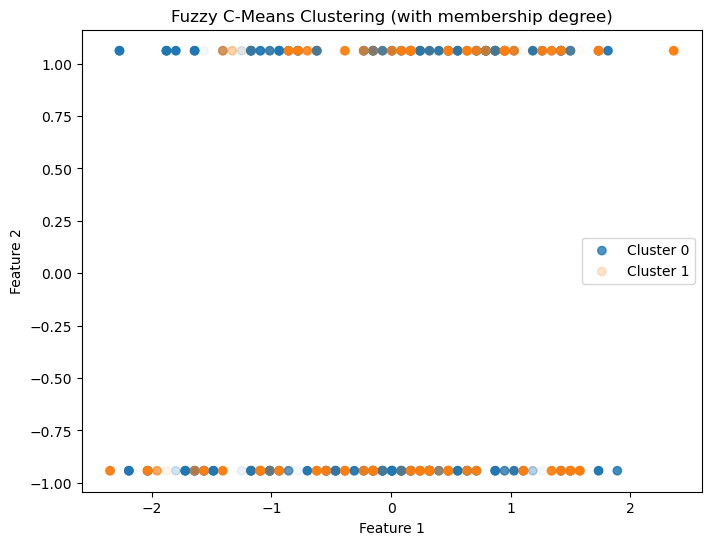

In [103]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

This plot shows the hard cluster assignments obtained from the Fuzzy C-Means algorithm, ignoring the membership degrees.

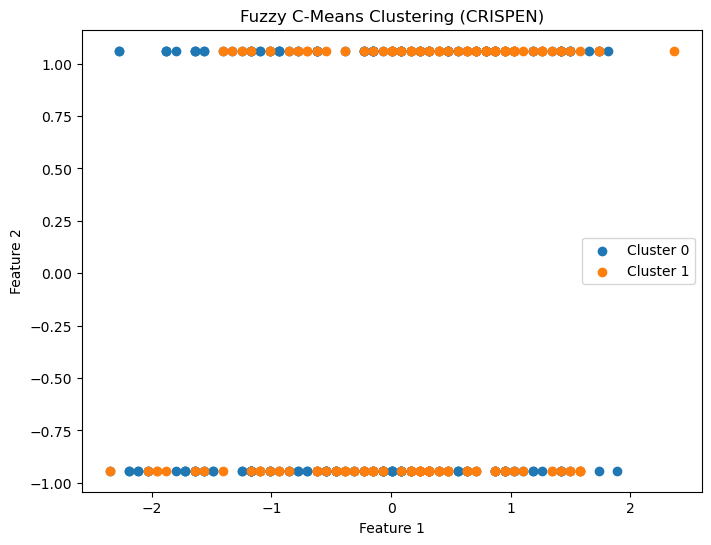

In [104]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

The following plot shows the Gaussian membership functions for the first feature of each cluster. Each curve represents how strongly a value belongs to a cluster, based on the cluster’s center and spread. Peaks indicate the cluster centers and the width shows how spread out the cluster is.

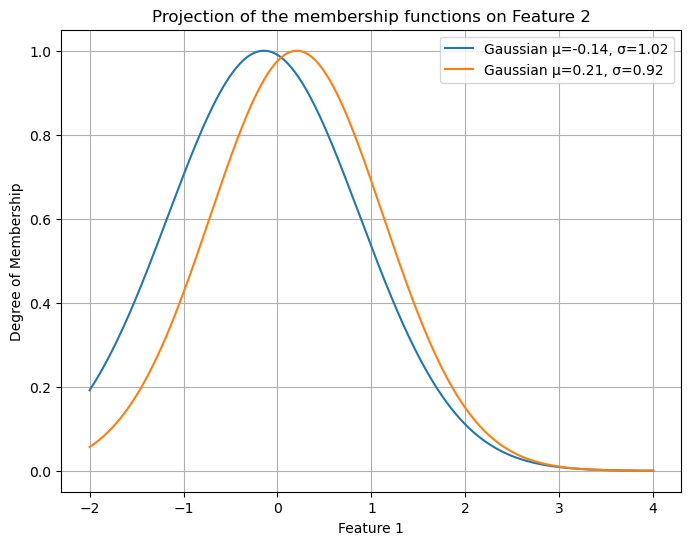

In [105]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

This section implements a Takagi-Sugeno-Kang (TSK) fuzzy inference system using PyTorch. Each rule's antecedent is represented by a Gaussian membership function for each input feature. The GaussianMF class takes cluster centers and standard deviations as parameters and computes, for each inpit sample, the distance to each cluster. 
Memberships can be aggregated either probabilistically, using Euclidean norm across features or via a min-type intersection and the final membership degree is calculated using Gaussian function of this distance.

The TSK class combines these Gaussian membership functions with linear consequents. Each rule has a linear function of the inputs plus a bias term. During the forward pass, the model computes the firing strengths of all rules, normalizes them to obtain membership probabilities, evaluates the consequent outputs of each rule and aggregates them via a weighted sum. This approach alows smooth interpolation between rules, enabling the model to approximate complex linear functions while maintaining the interpretability of fuzzy rules.

In [106]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs


This function updates the TSK model's consequents using least squares. It computes the normalized firing strengths for each rule, combines them with the inputs and bias term to form a design matrix and then solves for the consequent parameters analytically to minimize the squared error. 

In [107]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In the next code snippet, the function trains the TSK model using gradient descent. It uses the Adam optimizer to iteratively update all model parameters, including both the Gaussian membership functions and the linear consequents. During each epoch, the model predicts outputs, computes MSE loss relative to the target values and backpropagates the gradients to adjust the parameters accordingly.

In [108]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        # print(loss) commented so that the PDF file is not that large
        loss.backward()
        optimizer.step()

The function defined in this section implements the hybrid training procedure commonly used in ANFIS models. 

This approach alternates between two steps. Firstly, the gradient descent is applied to update the antecedent parameters while keeping the consequents fixed. Next, the consequents are updated using least squares while keeping the antecedents fixed.

This alternating process is repeated for a specified number of iterations, allowing the model to efficiently optimize both the nonlinear membership parameters and the linear rule consequents.

In [109]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

The code below creates a TSK model using the input feature size, the number of rules and the previously determined cluster centers and deviations. It also converts the training and test data into PyTorch tensors, preparing them for model training and evaluation.

In [110]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


Here, the TSK model is trained using the hybrid ANFIS procedure. 

In [111]:
# Training with ANFIS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))

Lastly, the trained model is used to predict the target values for the test set and its perfomance is measured using the mean squared error (MSE).

A value of 2656.5 was obtained for the MSE.

In [112]:
y_pred, _, _=model(Xte)

#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2656.5009765625
